In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .
%cd ..
import fasttext as ft

fatal: destination path 'fastText' already exists and is not an empty directory.
/content/fastText
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fastText
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4389851 sha256=93b2787af905a4dde4ce182c0515d61fe90c015d737f3efc25c16d7cc6ed49a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-56bmkbx4/wheels/a4/2f/6a/91d479a807787e092f667baec5df08801b0558f5676427f5a9
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2
/content


In [4]:
#学習用データと評価用データの読み込み
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/SIGNATE Student Cup 2022/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/SIGNATE Student Cup 2022/test.csv")

In [5]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [6]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [7]:
#評価用データの中身を確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


4    505
1    468
3    455
2     88
Name: jobflag, dtype: int64


<AxesSubplot:>

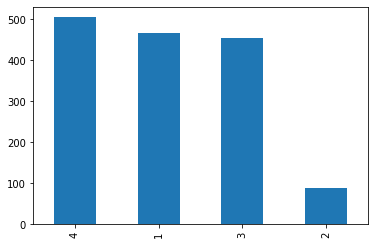

In [8]:
#学習用データに含まれるjobflagをカウント（＋可視化）
print(train['jobflag'].value_counts())
train['jobflag'].value_counts().plot(kind = 'bar')

In [9]:
#学習用データ, 評価用データのdescriptionに含まれる文字数を確認
train_length = train['description'].str.len()
test_length = test['description'].str.len()

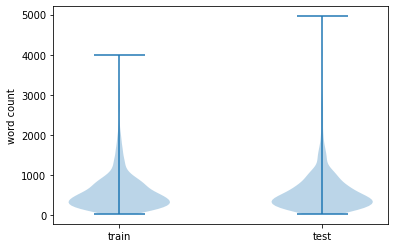

In [10]:
#可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([train_length, test_length])
ax.set_xticks([1, 2])
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('word count')
plt.show()

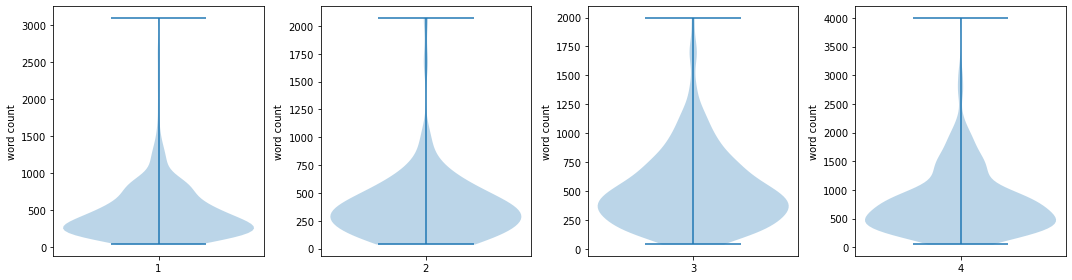

In [11]:
#学習用データの職業ラベル(jobflag)ごとの文字数を確認
fig = plt.figure(figsize = (15, 4))
for flag in [1, 2, 3, 4]:
    train_length_flag = train[train['jobflag'] == flag]['description'].str.len()
    ax = fig.add_subplot(1, 4, flag)
    ax.violinplot(train_length_flag)
    ax.set_xticks([1])
    ax.set_xticklabels([flag])
    ax.set_ylabel('word count')
plt.tight_layout()
plt.show()

In [12]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True)

In [13]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
import nltk
from nltk.stem.porter import PorterStemmer

# ストップワード
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        # !!! 単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split()] # if len(word) > 3]

        #ストップワードは削除
        clean_short_tokenized = [word for word in clean_short_tokenized if word not in stopwords]

        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# クリーニング結果の確認
print('#original\n', combined['description'][0])
print("-----")
print('#cleaned\n', combined_cleaned['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
 develop cut edg web applic perform superbl across platform work highli collabor environ cross function te

In [15]:
combined_cleaned

,id,description,jobflag
0,0,develop cut edg web applic perform superbl acr...,3.0
1,1,design develop high qualiti scalabl effici sol...,3.0
2,2,function point person network strategi work re...,4.0
3,3,work technic design develop releas deploy clou...,3.0
4,4,quantifi resourc requir task project relat ent...,4.0
...,...,...,...
3028,3028,manag develop interfac requir interfac specif ...,NaN
3029,3029,lead implement new statist model capabl requir...,NaN
3030,3030,configur zuora fulfil use casesidentifi area c...,NaN
3031,3031,gather translat document stakehold requir dema...,NaN


In [16]:
delimit_num = train.shape[0]
train = combined_cleaned.iloc[:delimit_num, :]
test = combined_cleaned.iloc[delimit_num:, :]

In [17]:
train

,id,description,jobflag
0,0,develop cut edg web applic perform superbl acr...,3.0
1,1,design develop high qualiti scalabl effici sol...,3.0
2,2,function point person network strategi work re...,4.0
3,3,work technic design develop releas deploy clou...,3.0
4,4,quantifi resourc requir task project relat ent...,4.0
...,...,...,...
1511,1511,support detail report statist analys model for...,1.0
1512,1512,collabor team support ml technic roadmap offer...,2.0
1513,1513,work execut busi leader identifi opportun impr...,1.0
1514,1514,lead design ideat session ensur build scalabl ...,3.0


In [18]:
test

,id,description,jobflag
1516,1516,build decis make model propos solut busi probl...,NaN
1517,1517,educ homeown benefit solar energi virtual pers...,NaN
1518,1518,design develop document implement web applic d...,NaN
1519,1519,appli advanc technic expertis skill implement ...,NaN
1520,1520,project manag deliv roadmapcollabor close coll...,NaN
...,...,...,...
3028,3028,manag develop interfac requir interfac specif ...,NaN
3029,3029,lead implement new statist model capabl requir...,NaN
3030,3030,configur zuora fulfil use casesidentifi area c...,NaN
3031,3031,gather translat document stakehold requir dema...,NaN


In [19]:
# 訓練用データのうち、訓練用と検証用に分割

from sklearn.model_selection import train_test_split
train_train, train_valid = train_test_split(train, test_size=0.3, random_state=0)

In [20]:
train_train

,id,description,jobflag
464,464,develop financi technic model report busi inte...,1.0
1366,1366,work increment agil sprint develop guid first ...,1.0
251,251,defin design author project busi function tech...,1.0
411,411,collabor project partner identifi product tech...,3.0
548,548,commun ownershipunderstand motiv sensit excell...,4.0
...,...,...,...
763,763,research develop improv open bank transact enr...,2.0
835,835,work highli distribut scalabl high transact sy...,3.0
1216,1216,identifi partnership opportunitiesdevelop new ...,4.0
559,559,function fast pace dynam environ util virtual ...,1.0


In [21]:
train_valid

,id,description,jobflag
1223,1223,appli behavior scientist advanc understand beh...,2.0
580,580,conceptu develop maintain dashboard visual inf...,1.0
9,9,maintain improv exist predict model evalu medi...,1.0
686,686,expertis lead team includ amazonian partner cu...,4.0
685,685,design implement new model extend exist models...,2.0
...,...,...,...
655,655,develop facilit negoti legal document key enga...,4.0
259,259,risk framework real time riskdeal state modelt...,3.0
481,481,develop manag standard ad hoc hr report analys...,1.0
1351,1351,pragmat problem solv abil deal complex systems...,3.0


In [22]:
# fasttextで学習させるための形式にする
fasttext_text_train = ''
for idx in train_train.index:
    text, label = train_train.loc[idx][1], train_train.loc[idx][2]
    fasttext_text_train += '__label__{} {}\n'.format(label, text)

fasttext_text_valid = ''
for idx in train_valid.index:
    text, label = train_valid.loc[idx][1], train_valid.loc[idx][2]
    fasttext_text_valid += '__label__{} {}\n'.format(label, text)

In [23]:
# fasttextモデルの学習には、データを一旦txtファイルにして読み込ませる必要がある
train_path = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/SIGNATE Student Cup 2022/fasttext_text_train.txt'
valid_path = '/content/drive/MyDrive/Colab Notebooks/SIGNATE/SIGNATE Student Cup 2022/fasttext_text_valid.txt'

f = open(train_path, 'w')
f.write(fasttext_text_train)
f.close()

f = open(valid_path, 'w')
f.write(fasttext_text_valid)
f.close()

In [24]:
# モデルの学習
# 検証用データを用いてハイパーパラメータのオートチューニングを行う
model = ft.train_supervised(input=train_path, 
                            autotuneValidationFile=valid_path,
                            autotuneDuration=600)

In [25]:
# 精度の確認（train）
ret = model.test(train_path)
print(ret)

(1061, 0.8699340245051838, 0.8699340245051838)


In [26]:
# 精度の確認（valid）
ret = model.test(valid_path)
print(ret)

(455, 0.7626373626373626, 0.7626373626373626)


In [27]:
# testデータを予測
preds = []

for idx in test.index:
  pred = int(float(model.predict(test.loc[idx]['description'])[0][0].replace('__label__', '')))
  preds.append(pred)

In [28]:
# 提出用データの確認
submit_df = pd.DataFrame([test['id']]).T
submit_df['pred'] = preds
submit_df

,id,pred
1516,1516,1
1517,1517,4
1518,1518,3
1519,1519,4
1520,1520,3
...,...,...
3028,3028,4
3029,3029,1
3030,3030,3
3031,3031,4
